In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings("ignore")

### Time series

A time series is data that depends on time. A good examples for such data sets are  stock market values or price fluctuation. Let's look at a simple dataset that shows amount of passengers flying per month:

In [2]:
data = pd.read_csv("AirPassengers.csv")
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


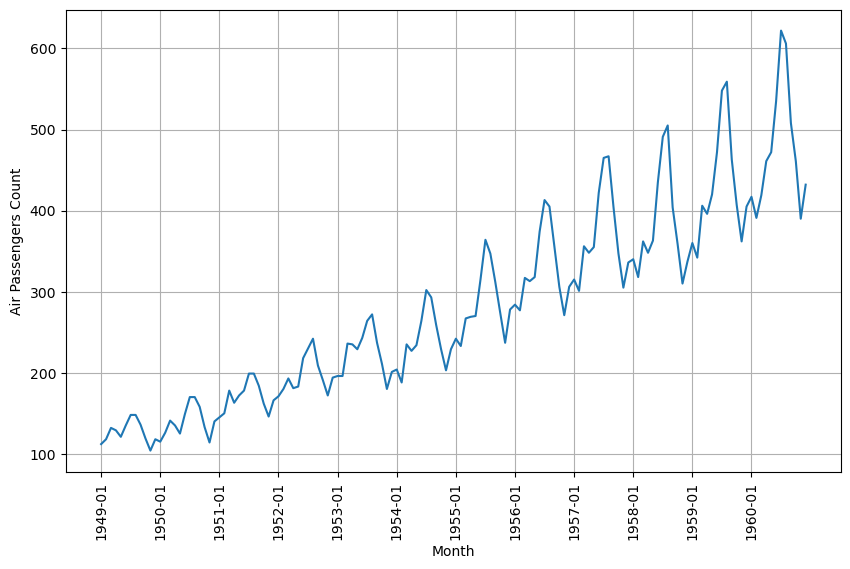

In [3]:
plt.figure(figsize=(10,6))
plt.xlabel("Month")
plt.ylabel("Air Passengers Count")

plt.plot(data['Month'], data['#Passengers'])
plt.xticks(data['Month'][::12],  rotation='vertical')
plt.grid()
plt.show()

While we can use linear regression directly on this data set (and we will do something similar at the end), this doesn't not give a good description of what is going on and doesnt not give good predictive power. In essence, this will give us general trend. However, it is possible to decompose this time series into 3 parts: general trend, seasonality (time depended fluctuations) and residues (the rest):

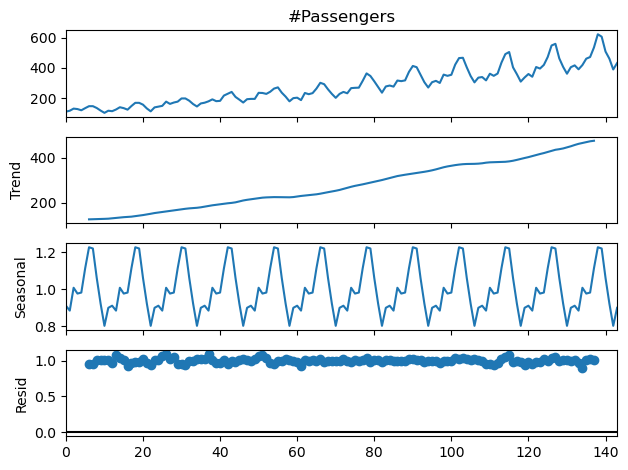

In [6]:
decom=seasonal_decompose(data.iloc[:,1],model='multiplicative', period=12)
decom.plot()
plt.show()

To get a better predictive power, common approach is to ask not how data depends on time, but how data depends on previous data. We can use "rolling window" technique:

In [7]:
X,y=[], []
lag=18
for i in range(len(data)-lag-1):
  X.append(data.iloc[i:i+lag,1])
  y.append(data.iloc[i+lag,1])
X=np.squeeze(X)
y=np.squeeze(y)
X[0], y[0]

(array([112, 118, 132, 129, 121, 135, 148, 148, 136, 119, 104, 118, 115,
        126, 141, 135, 125, 149], dtype=int64),
 170)

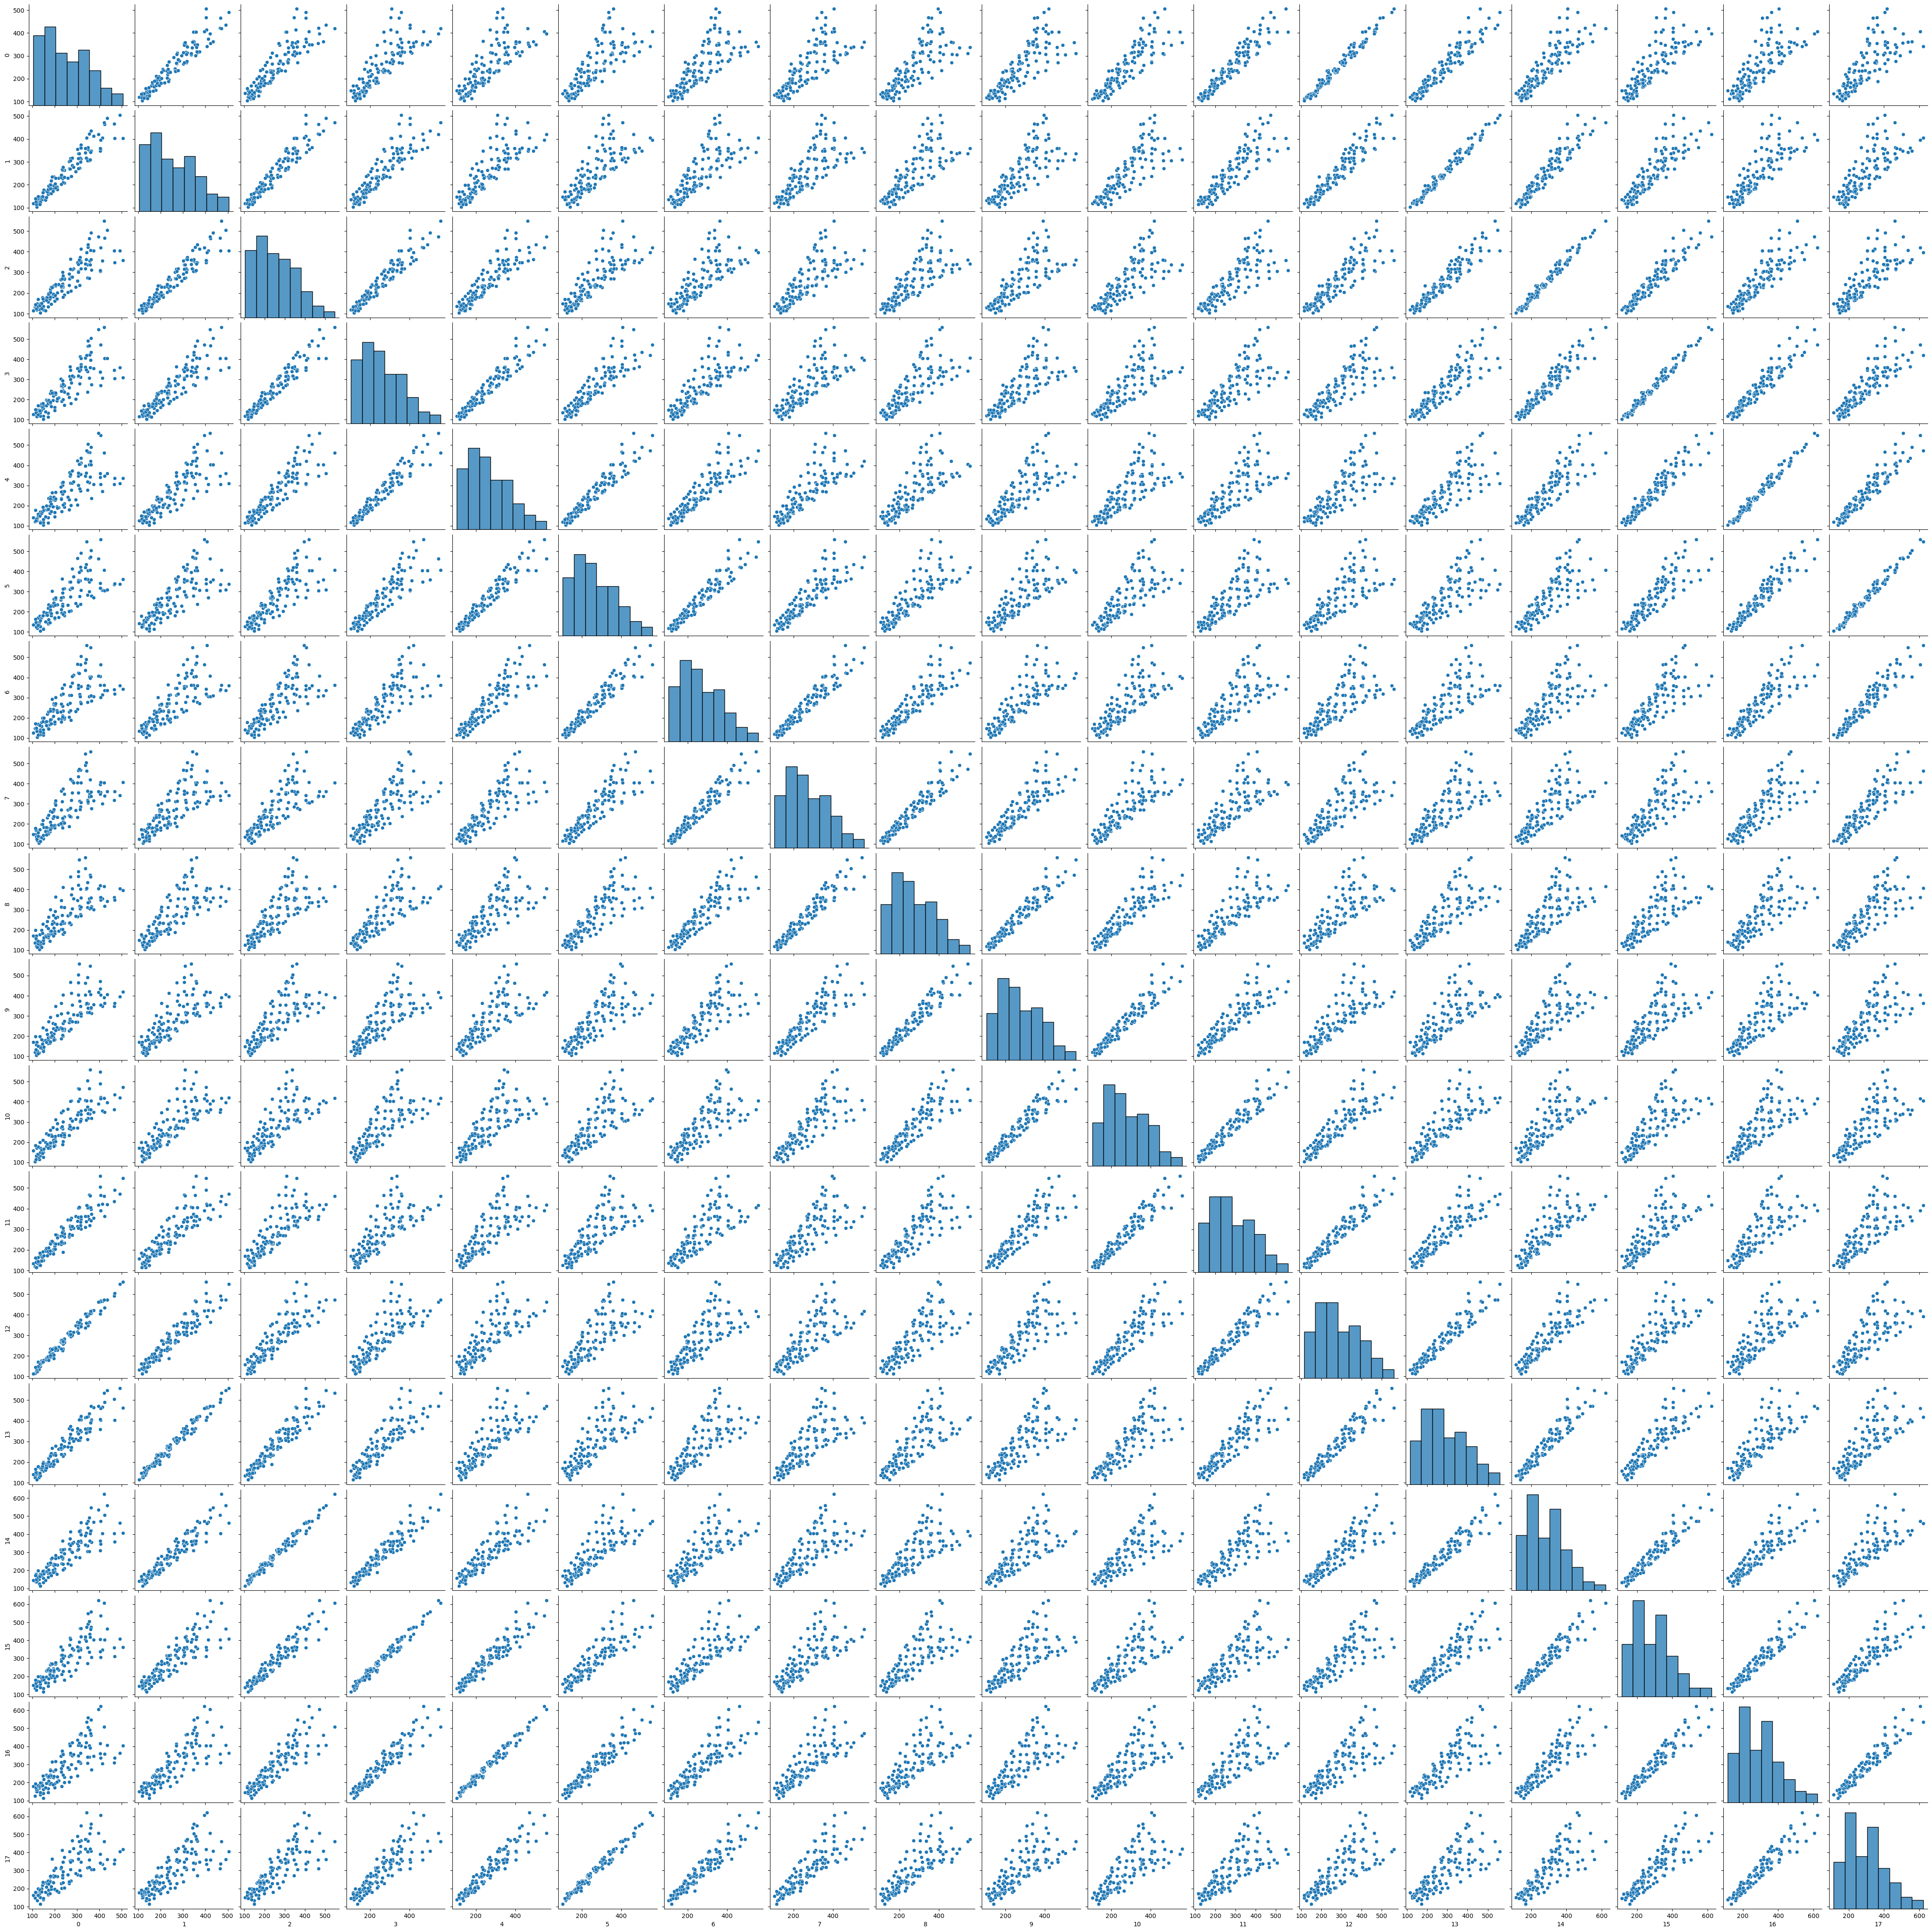

In [8]:
df=pd.DataFrame(X)
sns.pairplot(data=df)

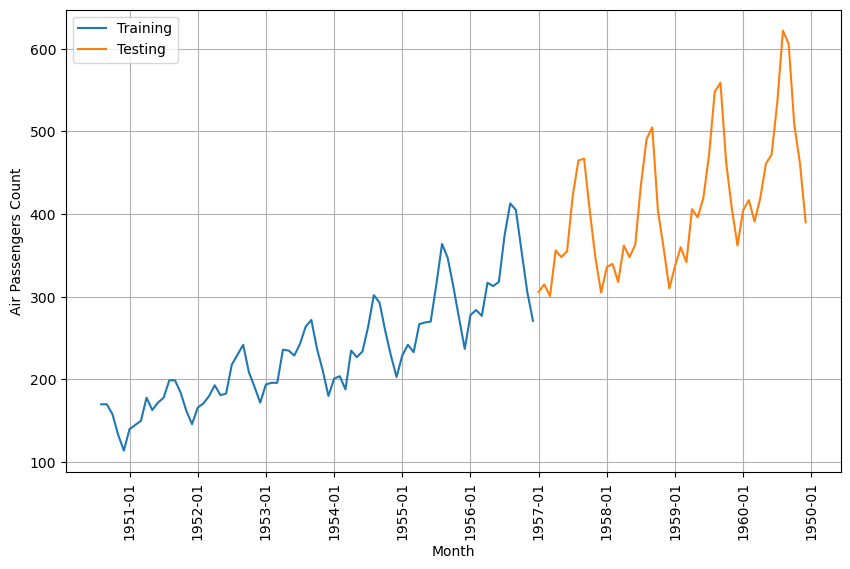

In [9]:
split_idx=48
x_train, y_train, x_test, y_test=X[:-split_idx], y[:-split_idx], X[-split_idx:], y[-split_idx:]

plt.figure(figsize=(10,6))
plt.xlabel("Month")
plt.ylabel("Air Passengers Count")

plt.plot(data['Month'][lag+1:-split_idx],y_train, label='Training')
plt.plot(data['Month'][-split_idx:],y_test, label='Testing')
plt.xticks(data['Month'][lag-6::12],  rotation='vertical')
plt.legend()
plt.grid()
plt.show()

Now let's use Linear Regression to predict the last two years. We have to be careful with our predictions and not use test set. For example, to get the first predicted value we can use the last 18 values on train set. To get the second value, we use last 17 values on train set plus our first predicted value; to get third value we use last 16 values of train set and first 2 predicted values and so on. Eventually, we will be using only predicted values:

In [10]:
regr = LinearRegression()
regr.fit(x_train, y_train)

LinearRegression()

In [11]:
predictingset=[x for x in x_train[-1]]
y_pred=[]
for i in range(len(x_test)):
    pred=regr.predict([predictingset])
    y_pred.append(pred[0])
    predictingset.append(pred[0])
    predictingset=predictingset[1:]
y_pred

[268.4719239368021,
 310.5459449022942,
 323.01295846172593,
 310.1983150424189,
 353.2618033121769,
 349.6919464102573,
 361.93350922542913,
 426.55425192088694,
 468.1667119137327,
 454.7345676619236,
 402.1738706337177,
 341.0910286555171,
 304.2590495822765,
 347.34413546147744,
 362.78130674676527,
 347.82555239914086,
 390.2939901448268,
 391.51186278780756,
 408.71034284745974,
 486.15097880827057,
 527.8582920878223,
 510.3881000120705,
 452.2613490632566,
 380.11748954250345,
 342.08276726355814,
 387.8532890279348,
 404.66271230228165,
 387.97902277056903,
 429.7604645320895,
 436.16776651105124,
 460.6390954366533,
 551.3407179525668,
 594.1723257909354,
 570.8488302363528,
 506.6314685507824,
 422.2961671599546,
 382.82949751942044,
 431.6531869348703,
 449.0322214704697,
 430.39996745233475,
 471.735948119937,
 483.95426498038717,
 518.0114650610004,
 623.0433082424576,
 667.4125267756565,
 636.9200312537963,
 565.3527526784247,
 468.1224645901344]

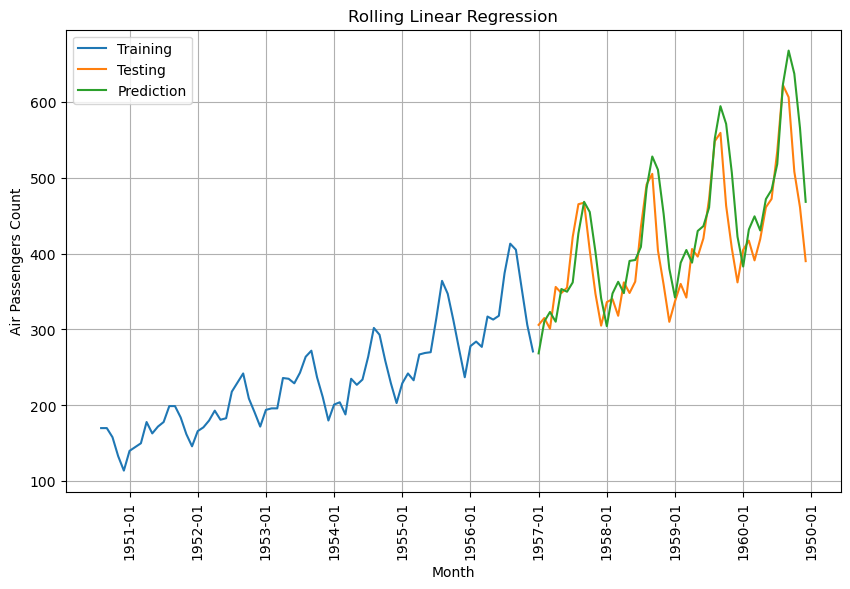

In [12]:
plt.figure(figsize=(10,6))
plt.xlabel("Month")
plt.ylabel("Air Passengers Count")

plt.plot(data['Month'][lag+1:-split_idx],y_train, label='Training')
plt.plot(data['Month'][-split_idx:],y_test, label='Testing')
plt.plot(data['Month'][-split_idx:],y_pred, label='Prediction')
plt.xticks(data['Month'][lag-6::12],  rotation='vertical')
plt.legend()
plt.title('Rolling Linear Regression')
plt.grid()
plt.show()

In [13]:
print('Coefficient of determination: %.2f' % r2_score(y_test, y_pred))

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Test RMSE: %.3f' % rmse)

Coefficient of determination: 0.59
Test RMSE: 50.678


### Other things.

Sometimes using some kind of smoothing is useful to remove outliers and improve forecasting. One of the easiest methods is rolling mean:

In [14]:
y_hat_rm = data.copy()
ma_window = 4
y_hat_rm['RollingMean'] = data['#Passengers'].rolling(ma_window).mean()
y_hat_rm.dropna(inplace=True)
y_hat_rm

,Month,#Passengers,RollingMean
3,1949-04,129,122.75
4,1949-05,121,125.00
5,1949-06,135,129.25
6,1949-07,148,133.25
7,1949-08,148,138.00
...,...,...,...
139,1960-08,606,558.75
140,1960-09,508,567.75
141,1960-10,461,549.25
142,1960-11,390,491.25


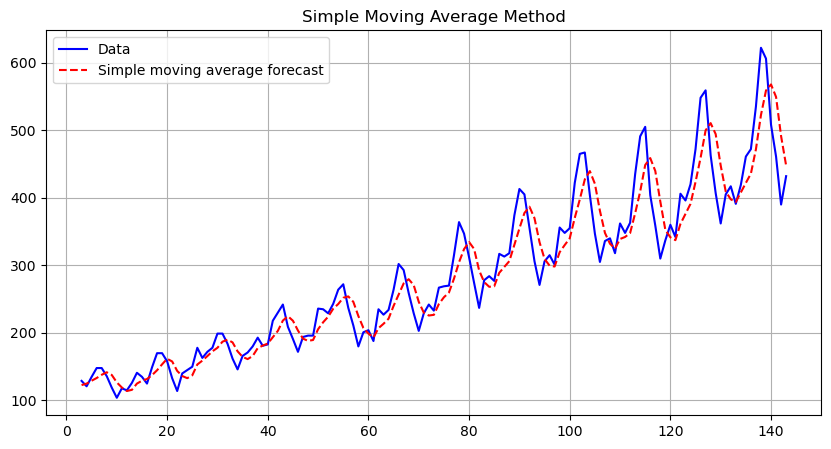

In [15]:
plt.figure(figsize=(10,5))

plt.plot(y_hat_rm['#Passengers'],label='Data',color='blue')
plt.plot(y_hat_rm['RollingMean'], label='Simple moving average forecast',linestyle='--', color='red')
plt.legend()
plt.title('Simple Moving Average Method')
plt.grid()
plt.show()

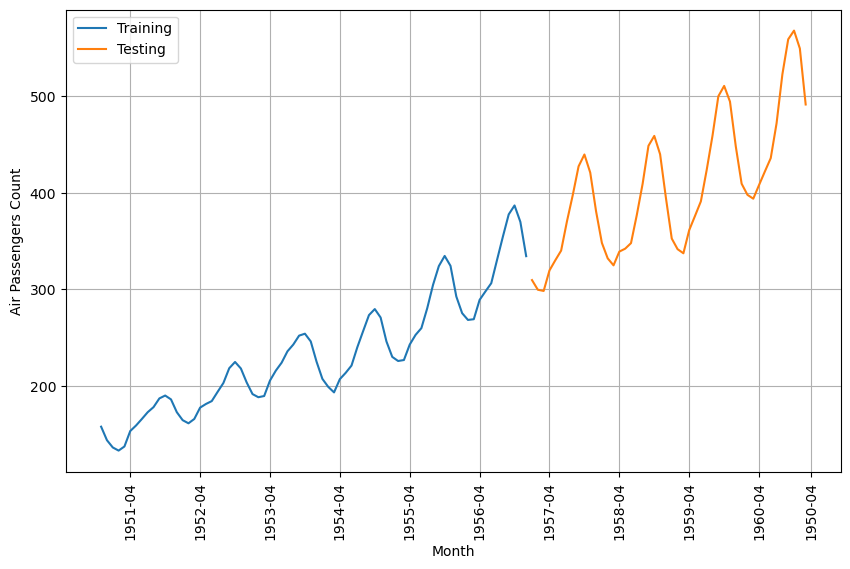

In [16]:
X,y=[], []
lag=18
for i in range(len(y_hat_rm)-lag-1):
  X.append(y_hat_rm.iloc[i:i+lag,2])
  y.append(y_hat_rm.iloc[i+lag,2])
X=np.squeeze(X)
y=np.squeeze(y)

split_idx=48
x_train, y_train, x_test, y_test=X[:-split_idx], y[:-split_idx], X[-split_idx:], y[-split_idx:]

plt.figure(figsize=(10,6))
plt.xlabel("Month")
plt.ylabel("Air Passengers Count")

plt.plot(y_hat_rm['Month'][lag+1:-split_idx],y_train, label='Training')
plt.plot(y_hat_rm['Month'][-split_idx:],y_test, label='Testing')
plt.xticks(y_hat_rm['Month'][lag-6::12],  rotation='vertical')
plt.legend()
plt.grid()
plt.show()

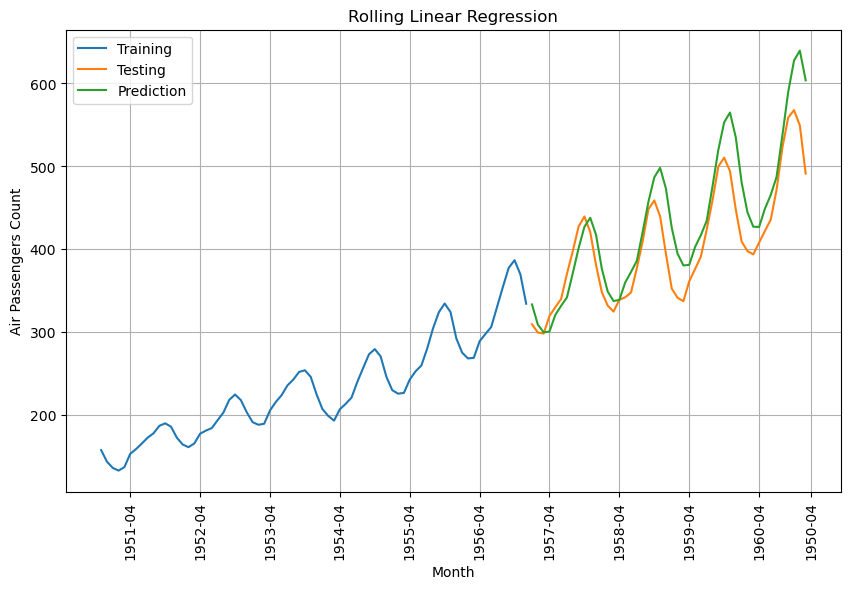

In [17]:
regr = LinearRegression()
regr.fit(x_train, y_train)

predictingset=[x for x in x_train[-1]]
y_pred=[]
for i in range(len(x_test)):
    pred=regr.predict([predictingset])
    y_pred.append(pred[0])
    predictingset.append(pred[0])
    predictingset=predictingset[1:]



plt.figure(figsize=(10,6))
plt.xlabel("Month")
plt.ylabel("Air Passengers Count")

plt.plot(y_hat_rm['Month'][lag+1:-split_idx],y_train, label='Training')
plt.plot(y_hat_rm['Month'][-split_idx:],y_test, label='Testing')
plt.plot(y_hat_rm['Month'][-split_idx:],y_pred, label='Prediction')
plt.xticks(y_hat_rm['Month'][lag-6::12],  rotation='vertical')
plt.legend()
plt.title('Rolling Linear Regression')
plt.grid()
plt.show()

We can plot Predictions versus Actual values. Below red line is just identity line where both would equal.

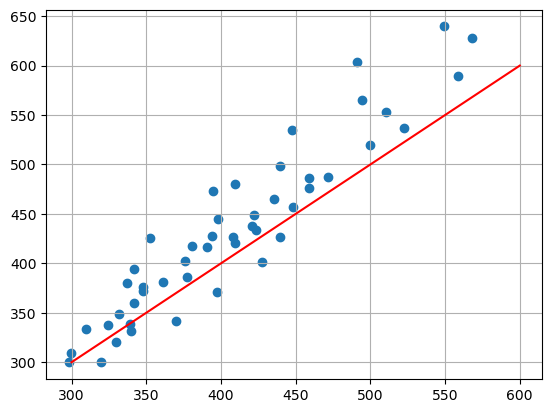

In [22]:
xv=np.linspace(300,600,1000)
plt.plot(xv,xv, 'r')

plt.scatter(y_test,y_pred)

plt.grid()
plt.show()

We can see we are a bit overestimating.

### Other models

Some common algorithms used for time-series forecasting:

1. ARIMA: It stands for Autoregressive-Integrated-Moving Average. It utilizes the combination of Autoregressive and moving averages to predict future values. 
2. EWMA/Exponential Smoothening: Exponentially weighted moving average or Exponential Smoothening serves as an upgrade to the Moving averages. It works by reducing the lag effect shown by moving averages by putting on more weight on values that occurred more recently. 
3. Dynamic Regression Models: This algorithm also takes other miscellaneous information into account such as public holidays, changes in law, etc.
4. Prophet: Prophet, which was released by Facebook’s Core Data Science team, is an open-source library developed by Facebook and designed for automatic forecasting of univariate time series data.
5. LSTM: Long Short-Term Memory (LSTM) is a type of recurrent neural network that can learn the order dependence between items in a sequence. It is often used to solve time series forecasting problems.

# Example of ARIMA


Let's take our original data set and split it into training and testing set.

In [23]:
train=pd.DataFrame(data.iloc[:-split_idx,1])
test=pd.DataFrame(data.iloc[-split_idx :,1])
test.reset_index(inplace=True,drop=True) 

ARIMA stands for Autoregressive Integrated Moving Average Model. It uses three parameters:

1. $p$ - order of autoregressive (AR in the name ) term. It is the number of lags that can be used to predict the future values. This does mean that it uses its own lags. For this part, current value $Y_i$ can be expressed as $$Y_i=b+w_1Y_{i-1}+...+w_pY_{i-p}+error.$$
where $b$ and $w$'s are parameters estimated by the model. In other words, this basically linear regression.
   
2. $d$ - integrated part ( I in the name ) that uses differencing. ARIMA requires your timeseries to be stationary. This basically means you should not have trends or seasonality. This is equivalent to saying that you should have constant mean and variance as you go through time. Main way to achieve this is by doing differencing:

   a. When $d=1$, you subtract previous value form current one, i.e. $Y_i=X_i-X_{i-1}$
   
   b. When $d=2$, you do this twice. So, $Y_i=(X_i-X_{i-1})-(X_{i-1}-X_{i-2})$

3. $q$ - order of moving average (MA in the name). In this part, instead of smoothing the curve like we did above. We look at how previous errors (difference between prediction and actual value) relate to current value. In this case current value $Y_i$ can be expressed as $$Y_i=b+e_i+e_{i-1}m_1...+e_{i-q}m_q.$$
where $e_i$ is error at time $i$, and $b$ and $m$'s are parameters.


Finally we combine the results to get our model:

$$Y_i=b+w_1Y_{i-1}+...+w_pY_{i-p}+e_i+e_{i-1}m_1...+e_{i-q}m_q$$

We have to decide on $p,d,q$ and then rest of the parameters are found by the model. So how to we choose these three paramters?

First we need to determine if the series is stationary. To do that we use ADF test. In essence, this is hypothesis test with null hypothesis being that series is non-stationary. It will produce a p-value, and so if the p-value is small, then the series is stationary. If it is not small, we need to do differencing.

In [25]:
# Perform the Augmented Dickey-Fuller test
result = adfuller(train)
print("ADF Statistic:", result[0])
print("p-value:", result[1])

# Interpret the results
if result[1] > 0.05:
    print("The data is not stationary.")
else:
    print("The data is stationary.")

ADF Statistic: 1.3402479596466974
p-value: 0.9968250481137263
The data is not stationary.


So our data is not stationary. Therefore our $d$ value has be more than zero. To apply differencing to dataframe we can use `.diff()`. So let's see what our data set looks like with $d=1$ and $d=2$. We will also plot Autocorrelation plot. It show correlation between our data and lagged data. It displays the correlation value on the y-axis against the lag (time difference) on the x-axis, with confidence intervals to highlight significant correlations. If the value is above shaded region, we have strong correlation. Here how you should understand this plot. If the values decrease  gradually, then we have trend in our data and if it peaks at regular intervals, then we have seasonality in our data. We don't want either of those things. In our case, we cant remove seasonality, but it's ok. SARIMA and SARIMAX models can deal with it. We can add period to our ARIMA command to force SARIMA model.

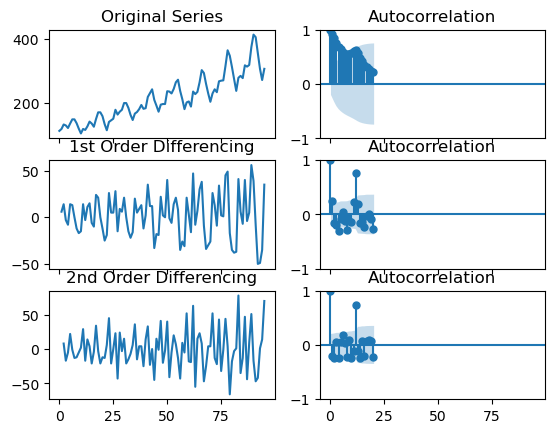

In [26]:
traindf=pd.DataFrame(train)

# Original Series
fig, ax = plt.subplots(3, 2, sharex=True)
ax[0, 0].plot(traindf); ax[0, 0].set_title('Original Series')
plot_acf(traindf, ax=ax[0, 1])

# 1st Differencing
ax[1, 0].plot(traindf.diff()); ax[1, 0].set_title('1st Order Differencing')
plot_acf(traindf.diff().dropna(), ax=ax[1, 1])

# 2nd Differencing
ax[2, 0].plot(traindf.diff().diff()); ax[2, 0].set_title('2nd Order Differencing')
plot_acf(traindf.diff().diff().dropna(), ax=ax[2, 1])

plt.show()

We can see that $d=2$ works for sure, and $d=1$ might work too. You can also see that without differencing our autocorrelation plot shows that we have a trend.

To determine $p$ value we will look at Partial Autocorrelation Plot. It is similar to Autocorrelation plot, except we exclude intermediate lags from consideration. This means it look at direct relation between data and given lagged data. The usual initial choice for $p$ is equal to the amount of lags that crosses significance level before first non-significant lag.

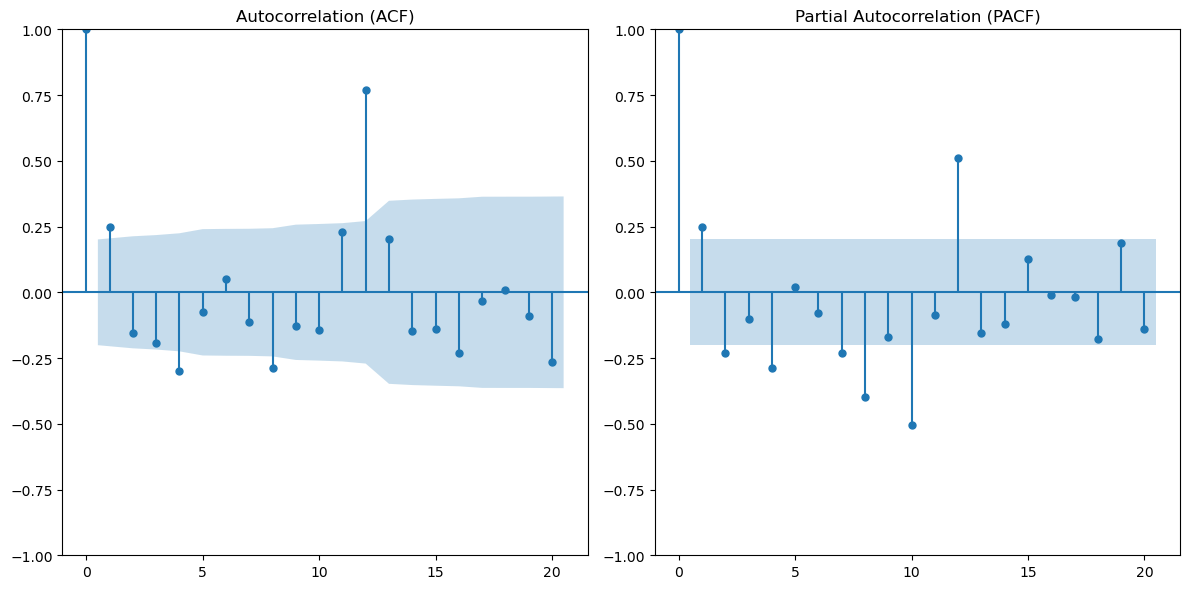

In [27]:
# Plot ACF and PACF for differenced data
plt.figure(figsize=(12, 6))

# ACF Plot
plt.subplot(1, 2, 1)
plot_acf(traindf.diff().dropna(), ax=plt.gca())
plt.title("Autocorrelation (ACF)")

# PACF Plot
plt.subplot(1, 2, 2)
plot_pacf(traindf.diff().dropna(), ax=plt.gca())
plt.title("Partial Autocorrelation (PACF)")

plt.tight_layout()
plt.show()

We can see on PACF plot that first lag is the most dramatic, so $p=1$ is a good choice. Argument can be made for $p=2$ or $p=3$ as well though, but either way might work. We will test later both values.

Finally, to determine $q$ value is very similar to $p$, except we look at ACF plot. Again $q=1$ is a good value, but argument can be made for $q=2$ as well.

So let's train a model with some of the chosen values and see if we should change any of them.

In [49]:
model = ARIMA(train, seasonal_order=(3,1,2,12)) #p=3, d=1, q=1, period =12
model_fit = model.fit()
print(model_fit.summary())

                                  SARIMAX Results                                  
Dep. Variable:                 #Passengers   No. Observations:                   96
Model:             ARIMA(3, 1, [1, 2], 12)   Log Likelihood                -370.080
Date:                     Wed, 24 Sep 2025   AIC                            752.160
Time:                             14:11:02   BIC                            766.745
Sample:                                  0   HQIC                           758.023
                                      - 96                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0890      6.222     -0.014      0.989     -12.284      12.106
ar.S.L24       0.9533      4.977      0.192      0.848      -8.802      10.709
ar.S.L36    

There a lot of information here. But here are the key places to look:

1. Table in the middle shows various information about parameters. For example, `ar.S.L12`, `ar.S.L24` and `ar.S.L36` are three AR paramters given by $p=3$. In this table, look at th column "$P>|z|$". This column show how significant these parameters are. The smaller the value the better (usually we want them to be less than 0.05). Right our values are too large. This means we can reduce $p$ and $q$.
2. Another useful values are AIC and BIC in the top table. We want to minimize those using $p$ and $q$ values only. It incomporates goodness of fit and simplicity of the model. Note, it doesnt work with $d$ value, only $p$ and $q$. In our case, we dont have to deal with it.

In [51]:
model = ARIMA(train, seasonal_order=(1,1,1,12))
model_fit = model.fit()
print(model_fit.summary())

                                SARIMAX Results                                 
Dep. Variable:              #Passengers   No. Observations:                   96
Model:             ARIMA(1, 1, [1], 12)   Log Likelihood                -370.441
Date:                  Wed, 24 Sep 2025   AIC                            746.882
Time:                          14:14:09   BIC                            754.175
Sample:                               0   HQIC                           749.814
                                   - 96                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.9880      0.029     33.781      0.000       0.931       1.045
ma.S.L12      -0.7384      0.252     -2.933      0.003      -1.232      -0.245
sigma2       302.6248     88.583    

So, let's train our chosen model and see how it fits with test set

In [32]:
history = [x for x in train['#Passengers']]
predictions = []
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, seasonal_order=(1,1,1,12))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test.iloc[t][-1]
	history.append(obs)
	#print('predicted=%f, expected=%f' % (yhat, obs))

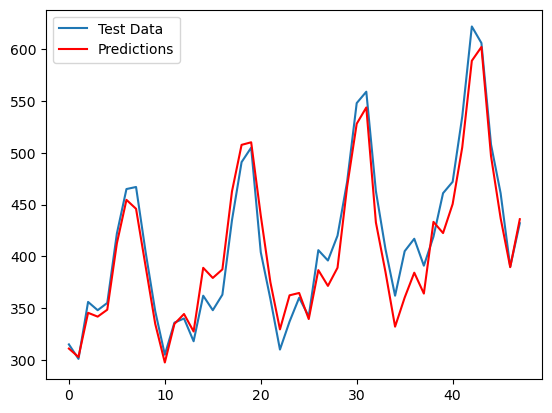

In [33]:
plt.plot(test, label='Test Data')
plt.plot(predictions, color='red', label='Predictions')
plt.legend()
plt.show()

In [34]:
print('Coefficient of determination: %.2f' % r2_score(test, predictions))

rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Coefficient of determination: 0.93
Test RMSE: 20.839


Here what it would look if we didn't use seasonality:

In [53]:
model = ARIMA(train, order=(2,1,1)) #p=3, d=1, q=1
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                   96
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -423.463
Date:                Wed, 24 Sep 2025   AIC                            854.927
Time:                        14:14:56   BIC                            865.142
Sample:                             0   HQIC                           859.054
                                 - 96                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0162      0.112      9.100      0.000       0.797       1.235
ar.L2         -0.4408      0.125     -3.521      0.000      -0.686      -0.195
ma.L1         -0.8025      0.114     -7.056      0.0

In [54]:
history = [x for x in train['#Passengers']]
predictions = []
for t in range(len(test)):
	model = ARIMA(history, order=(2,1,1))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test.iloc[t][-1]
	history.append(obs)
	#print('predicted=%f, expected=%f' % (yhat, obs))

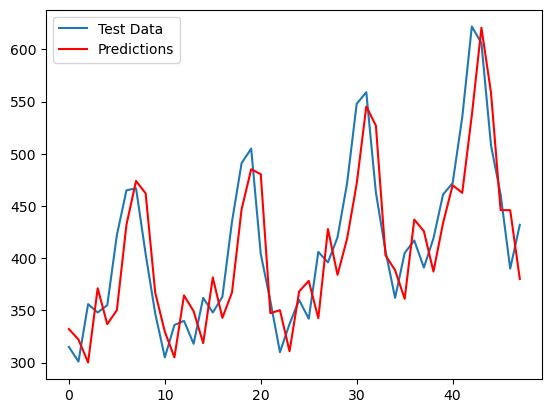

In [55]:
plt.plot(test, label='Test Data')
plt.plot(predictions, color='red', label='Predictions')
plt.legend()
plt.show()

In [56]:
print('Coefficient of determination: %.2f' % r2_score(test, predictions))

rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Coefficient of determination: 0.71
Test RMSE: 41.980
